In [1]:
import requests as rq
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from TCGA_files import get_tcga_tissue
#from ensembleAPI import geneinfo, genesinfo
from sklearn import metrics
from hsbmpy import *
import os

## query many

In [11]:
level = 1
algorithm = 'topsbm'
directory = "datasets/tcga/mirna"
L=get_max_available_L(directory, algorithm)
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1
0,TCGA-B6-A0X4
1,TCGA-AQ-A1H2
2,TCGA-AN-A041
3,TCGA-B6-A0WY
4,TCGA-E2-A1LL


In [12]:
#df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t')
#df_files.set_index('SAMPID', inplace=True)
#df_files.dropna(how='all', axis=0).to_csv("%s/files.dat"%directory, index=True, header=True)

In [14]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0]).dropna(axis=1, how='all').dropna(axis=0, how='all')
samples = pd.read_csv("%s/%s/%s_level_0_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
samples=samples[samples!="nan"]
df_files = df_files.reindex(index=samples).dropna(how="all", axis=0).fillna("unknown")
labels = df_files.columns
print(labels)

Index(['cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id.1',
       'level_0', 'index', 'cases.0.diagnoses.0.morphology',
       'cases.0.diagnoses.0.primary_diagnosis',
       'cases.0.diagnoses.0.tissue_or_organ_of_origin',
       'cases.0.diagnoses.0.tumor_grade', 'cases.0.diagnoses.0.tumor_stage',
       'cases.0.project.disease_type', 'cases.0.project.primary_site',
       'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id',
       'cases.0.diagnoses.0.morphology.1',
       'cases.0.diagnoses.0.primary_diagnosis.1',
       'cases.0.diagnoses.0.tissue_or_organ_of_origin.1',
       'cases.0.diagnoses.0.tumor_grade.1',
       'cases.0.diagnoses.0.tumor_stage.1', 'cases.0.project.disease_type.1',
       'cases.0.project.primary_site.1', 'cancer.type', 'Subtype_mRNA',
       'Subtype_Selected'],
      dtype='object')


In [15]:
labels=['Subtype_Selected']
#labels = ['cancer.type', "Subtype_Selected"]
#labels=['SMTS', "SMTSD"]
#labels=["Type", "Subtype"]
#labels = ["primary_site", "tissue_hd"]
df_files[labels[0]].unique()

array(['BRCA.LumA', 'BRCA.Basal', 'BRCA.Normal', 'BRCA.LumB', 'BRCA.Her2',
       'unknown'], dtype=object)

True Subtype_Selected 3


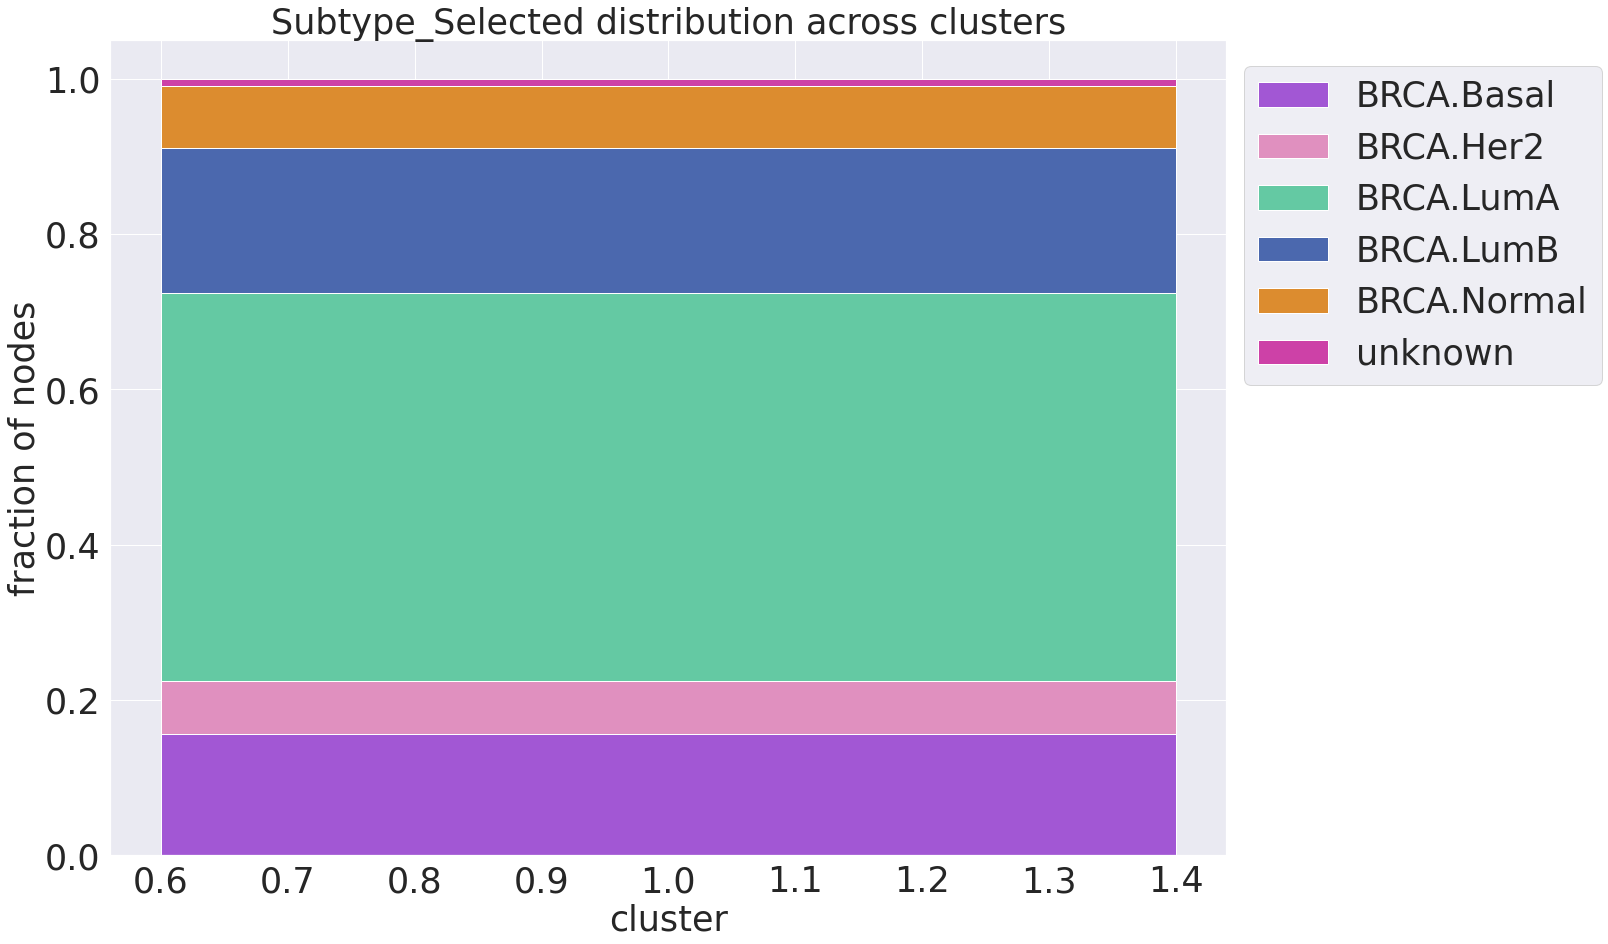

True Subtype_Selected 2


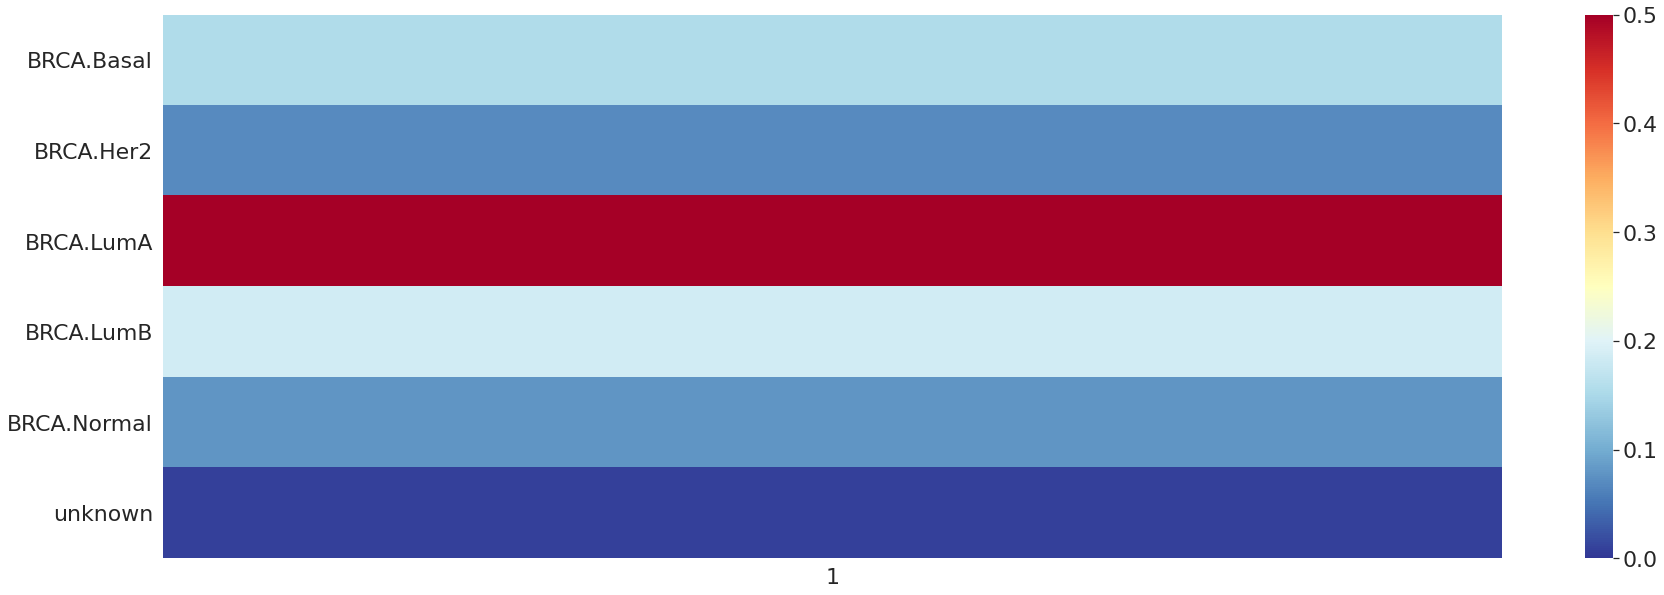

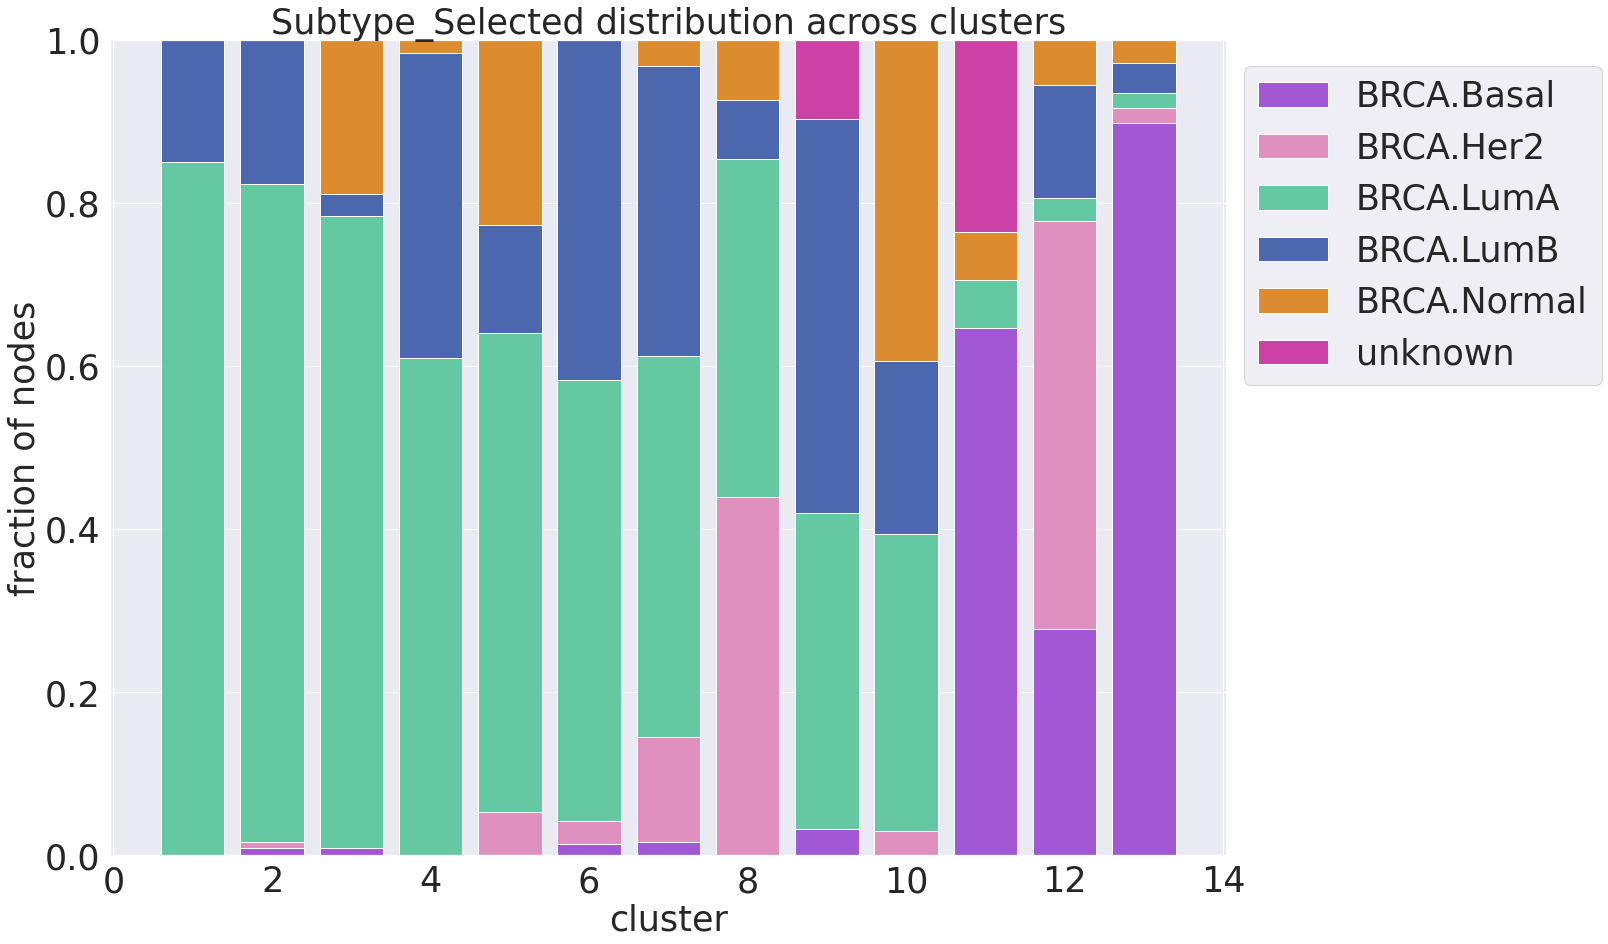

True Subtype_Selected 1


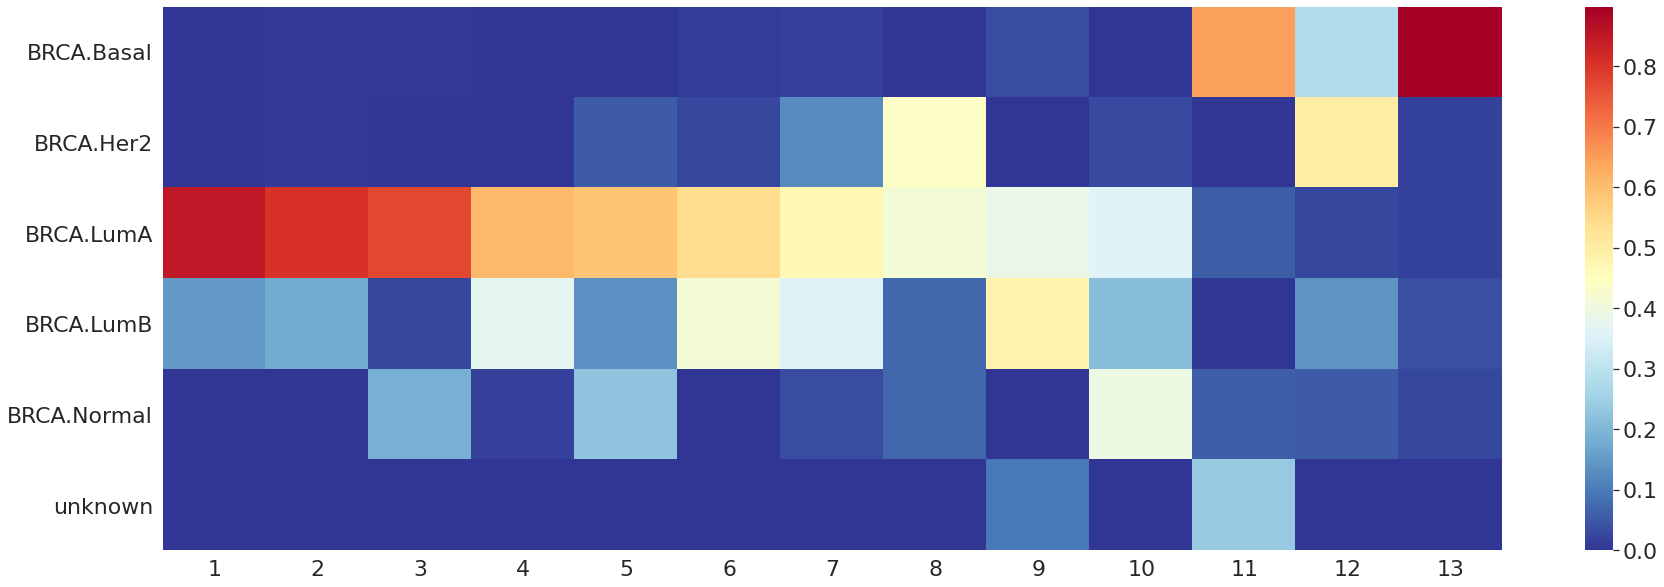

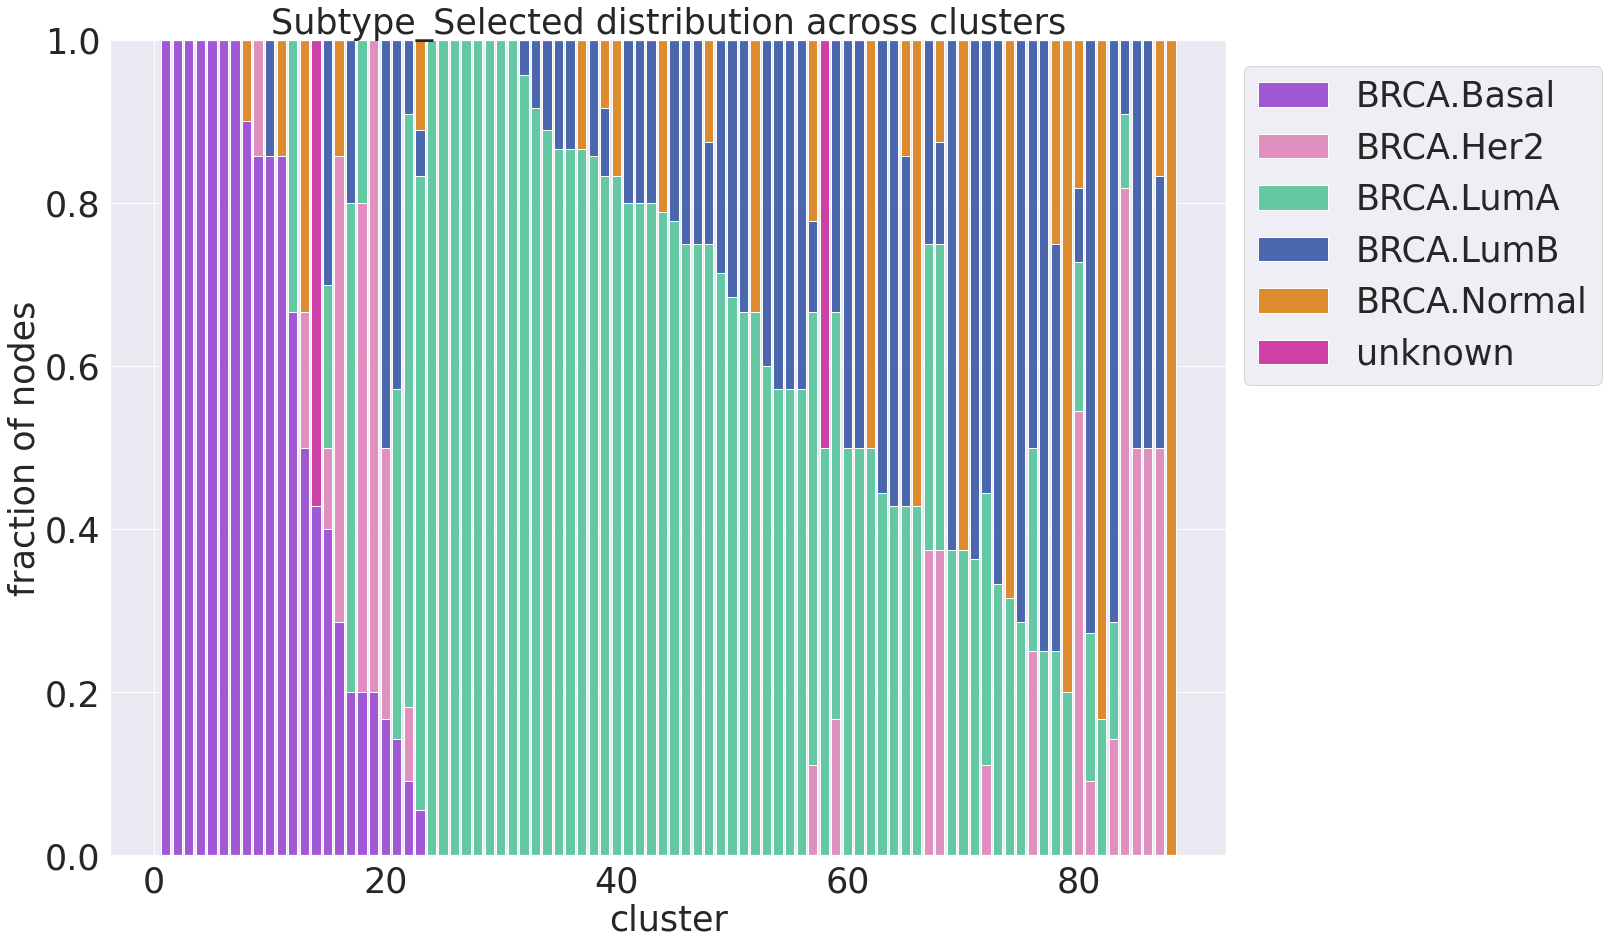

False Subtype_Selected 3


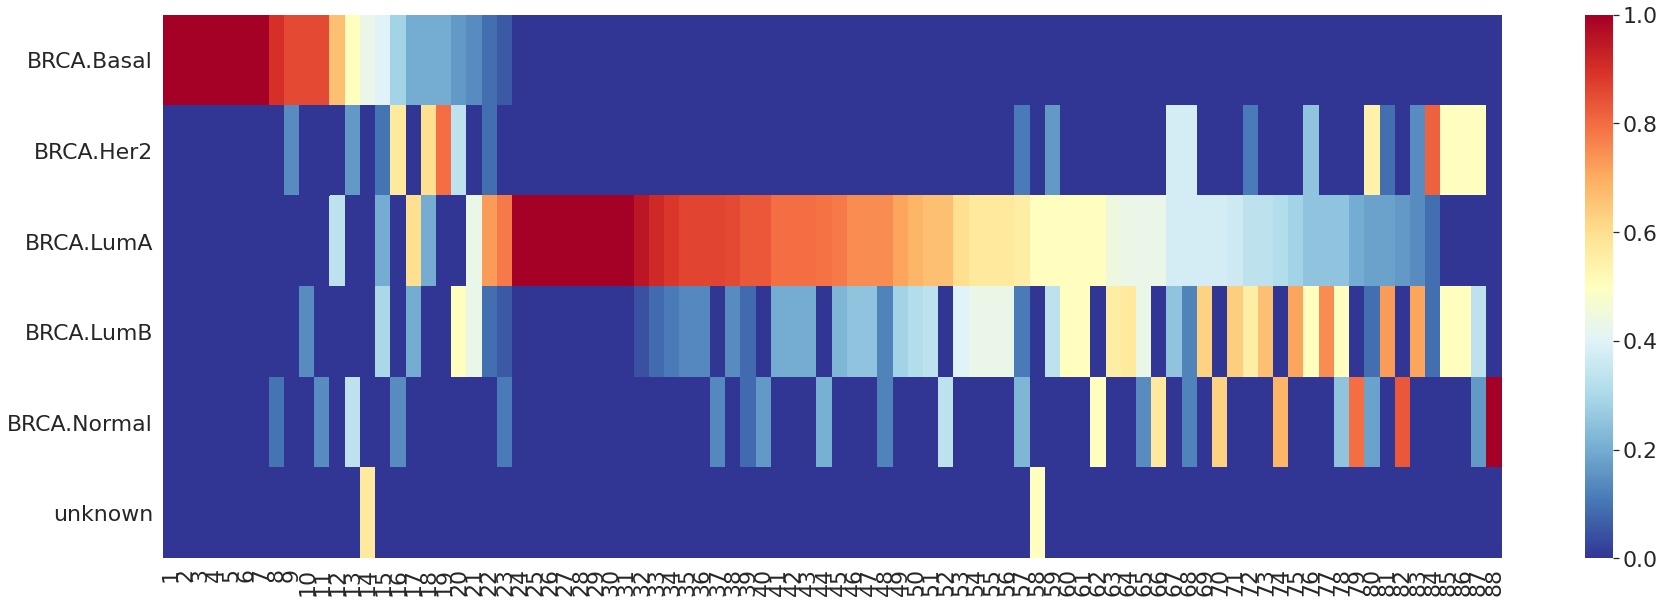

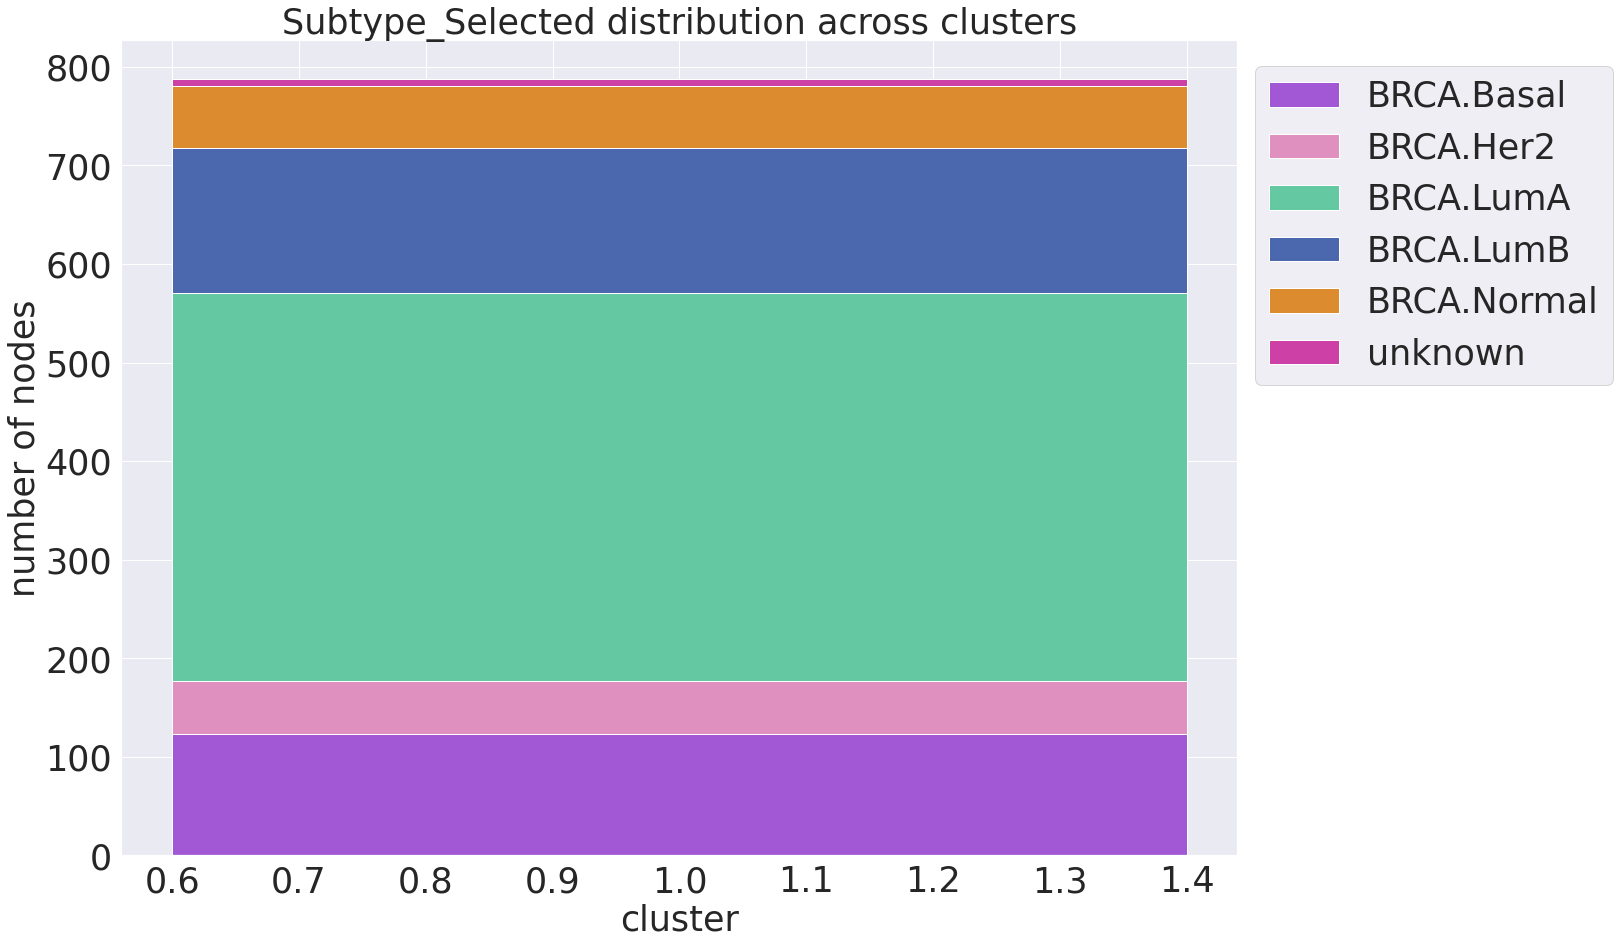

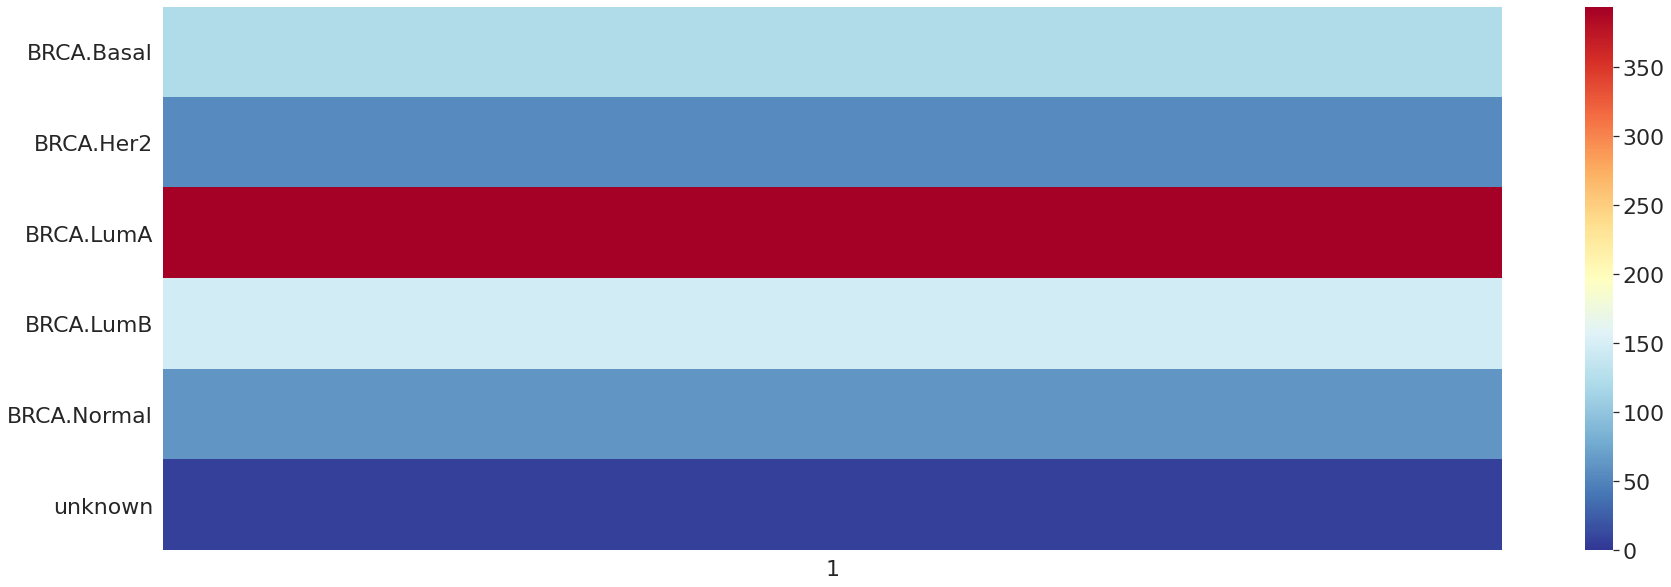

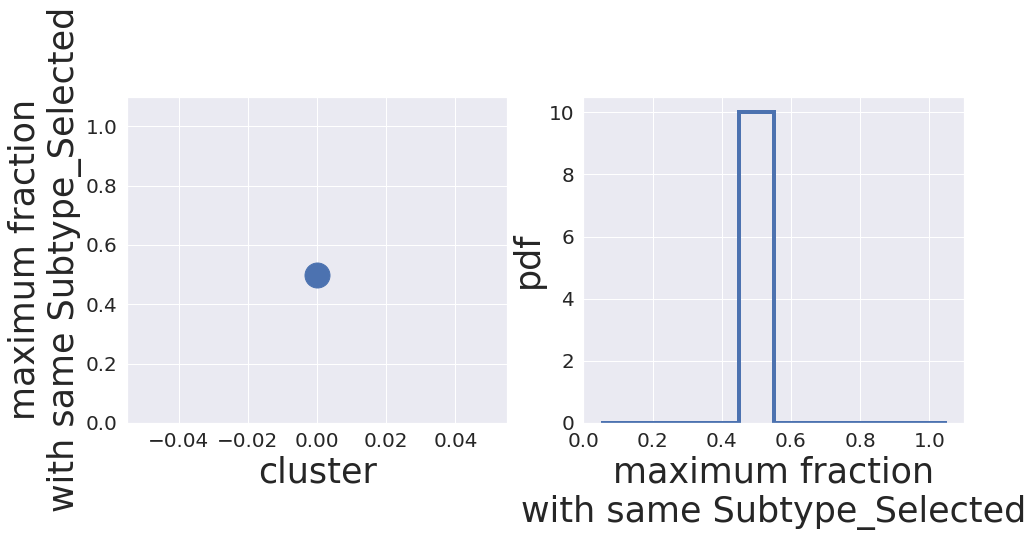

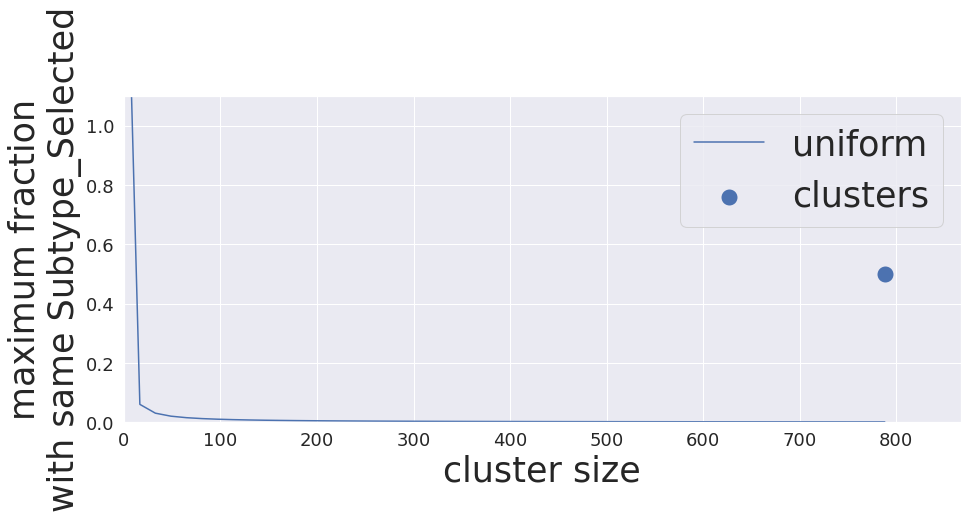

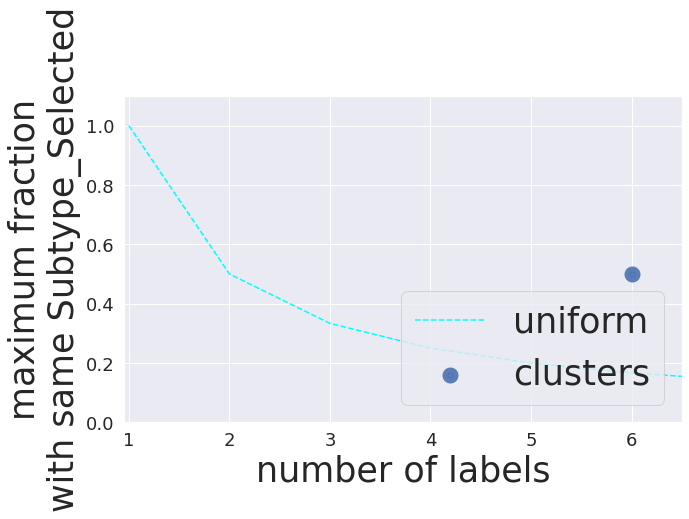

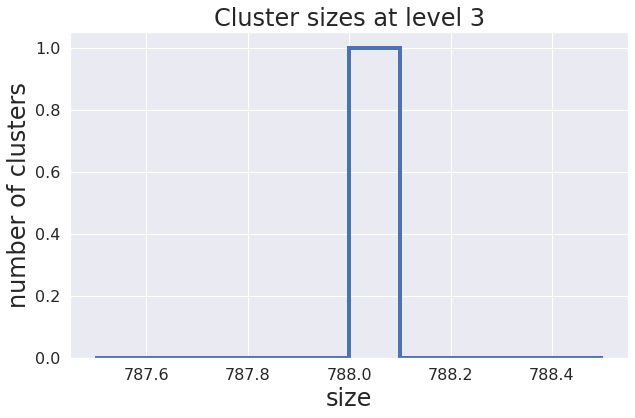

False Subtype_Selected 2


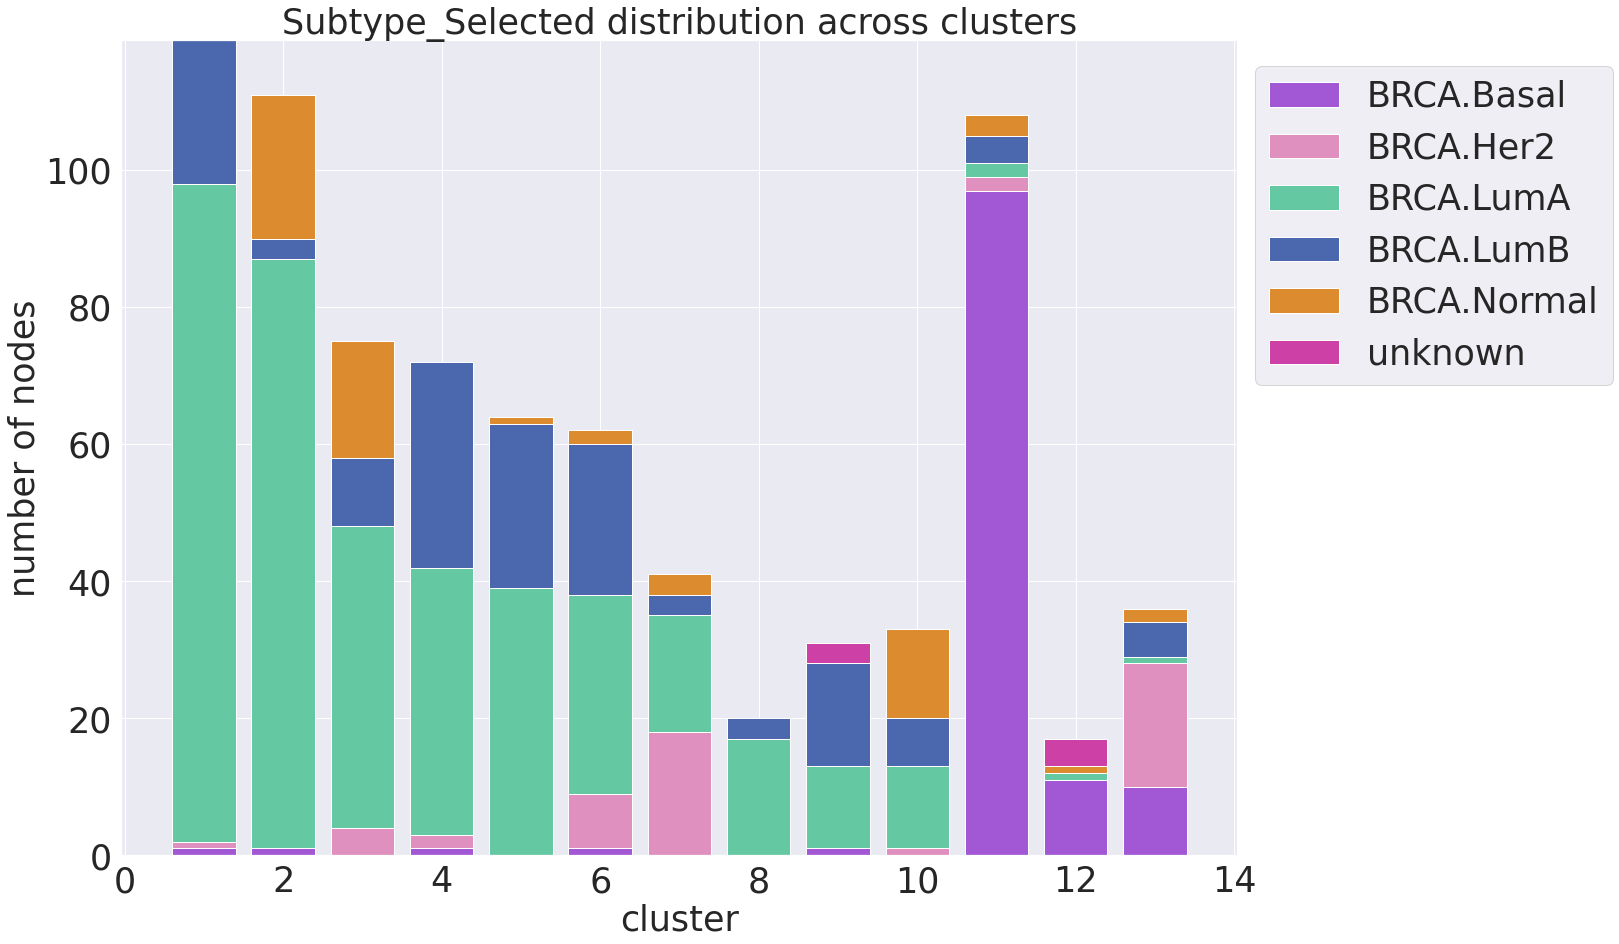

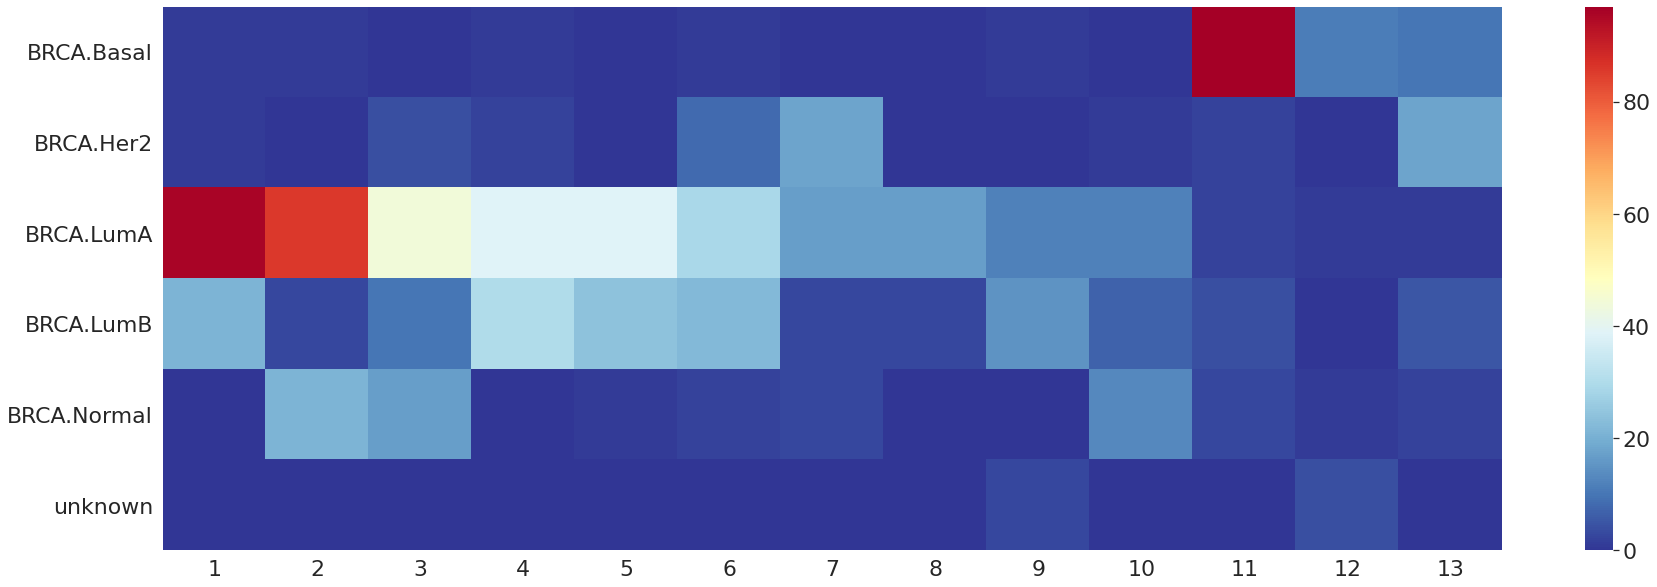

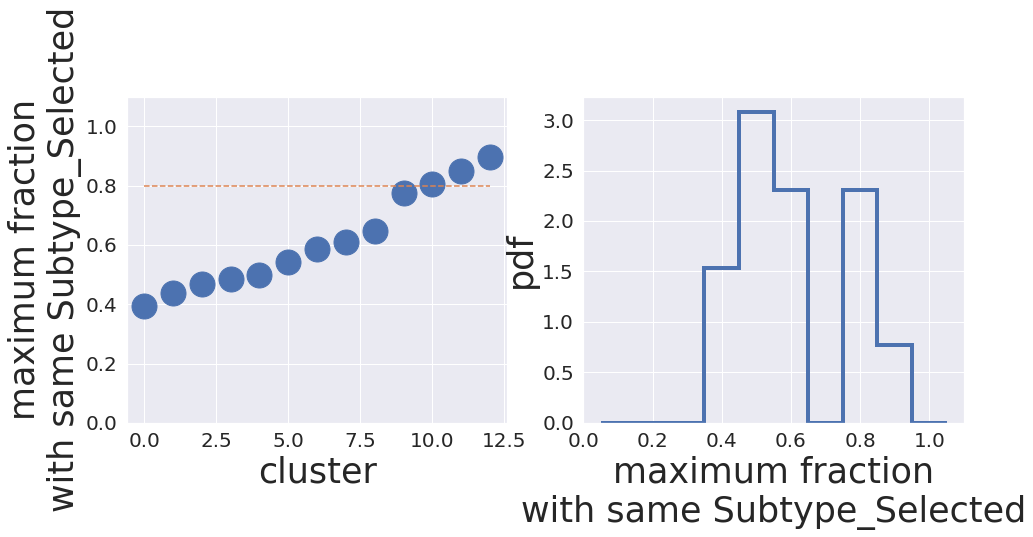

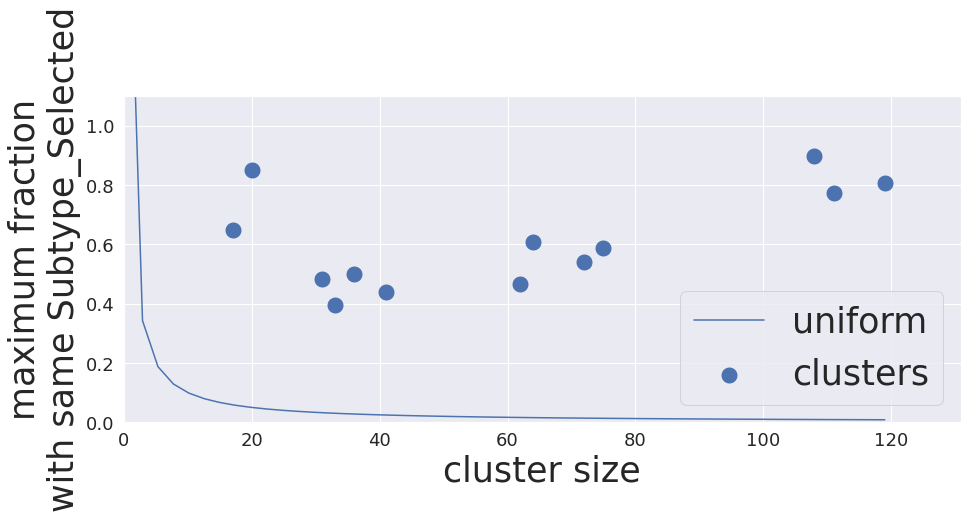

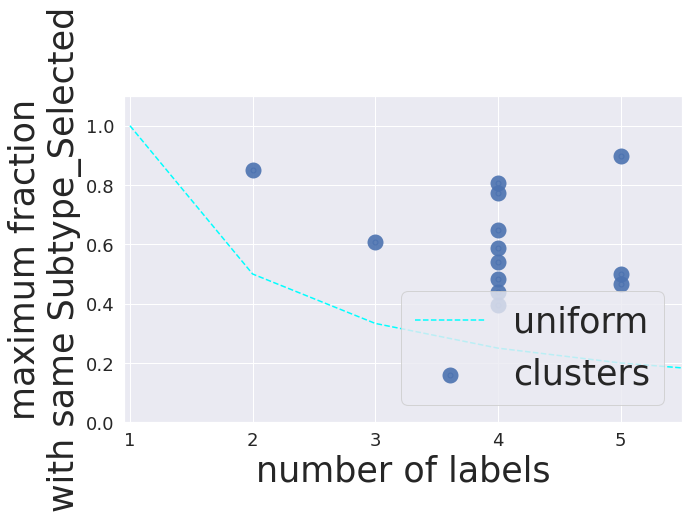

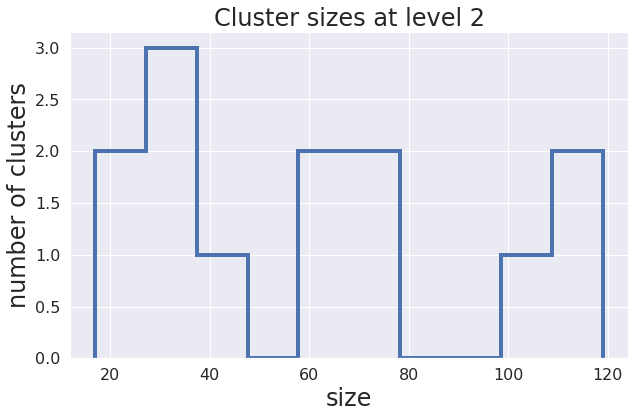

False Subtype_Selected 1


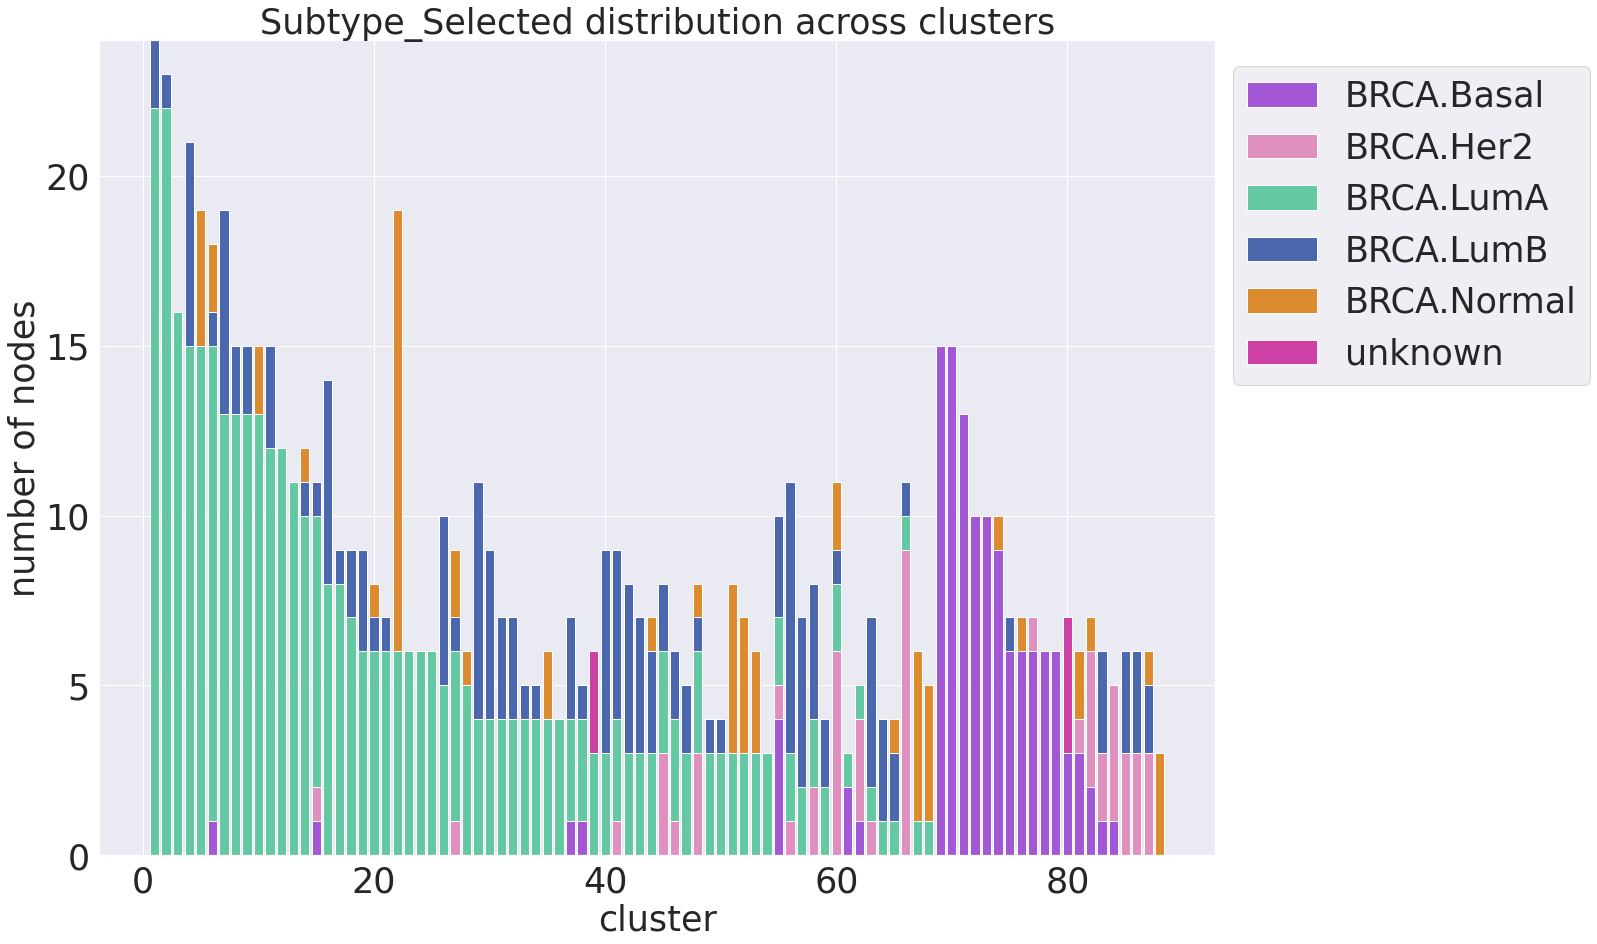

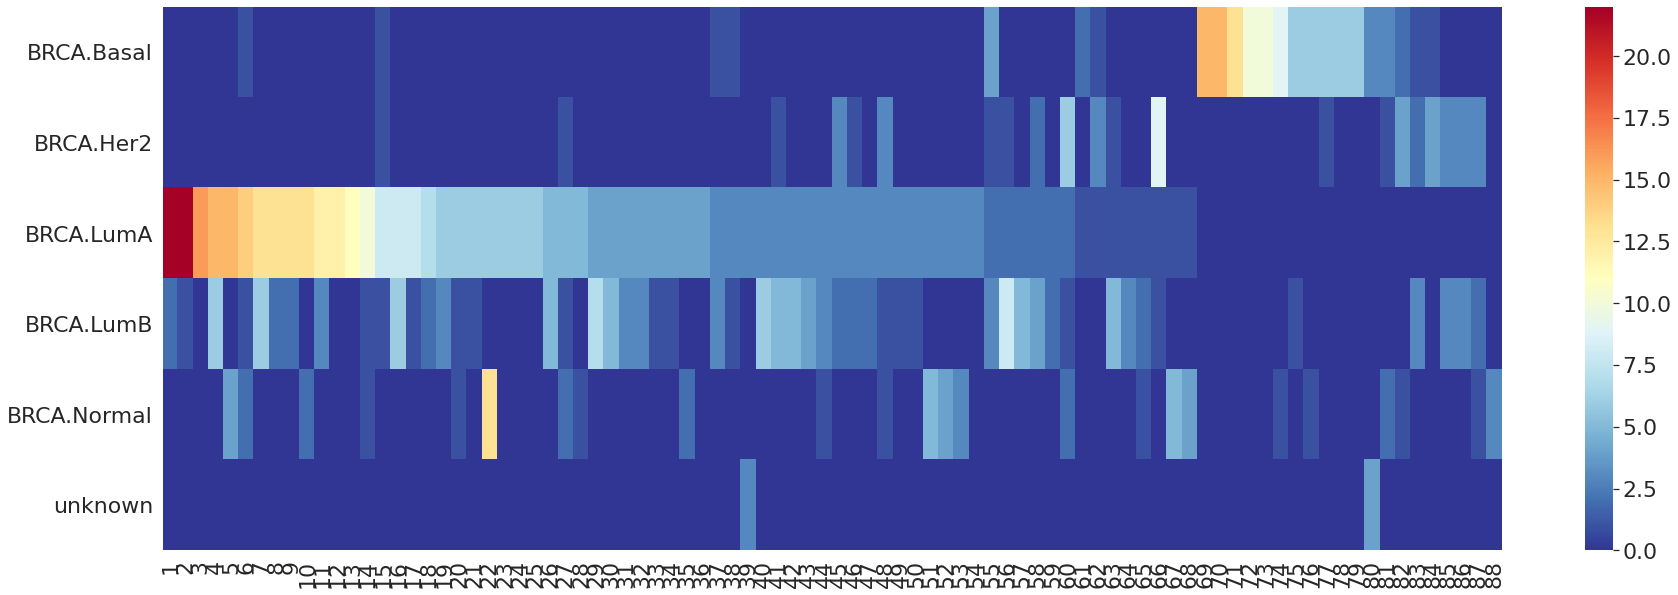

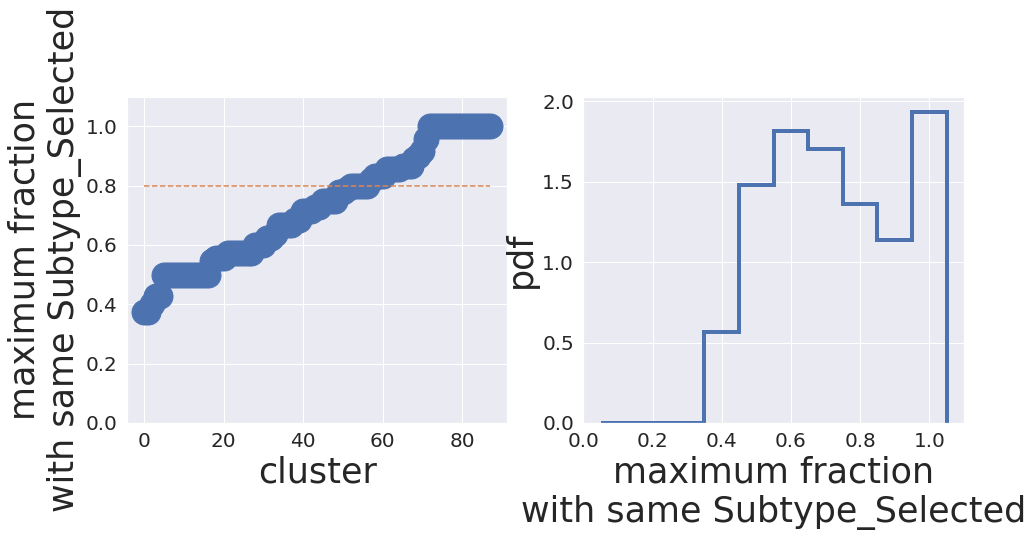

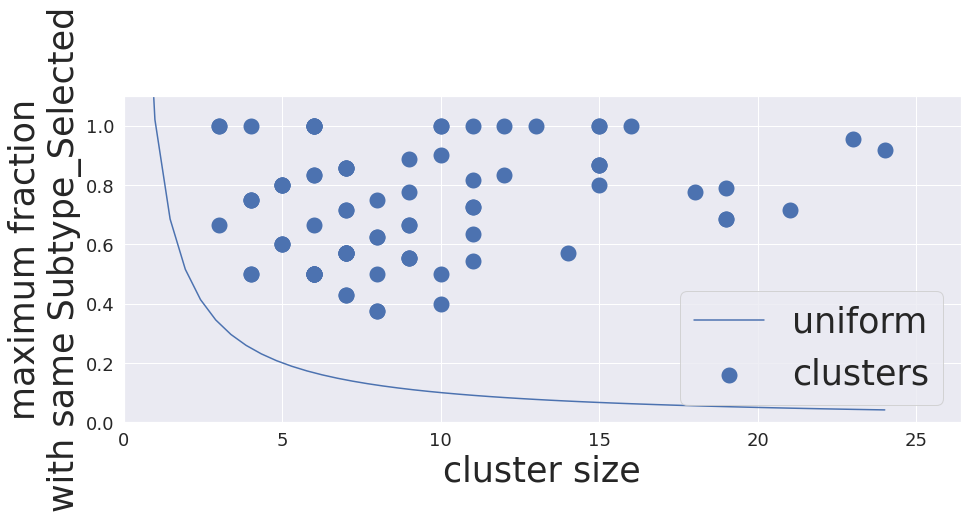

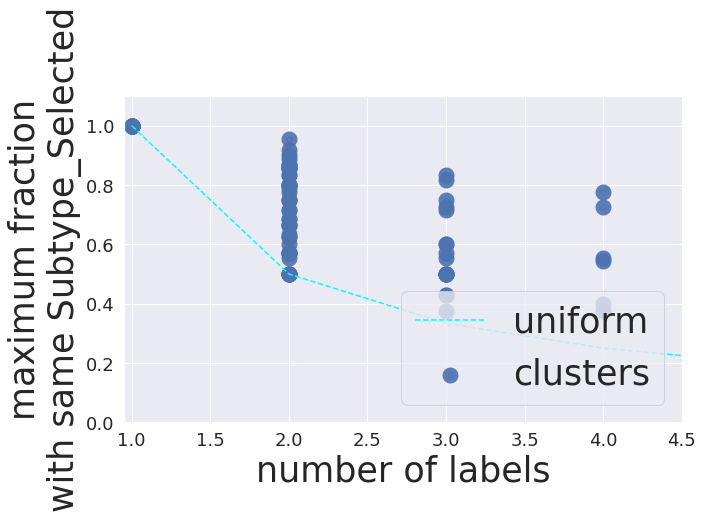

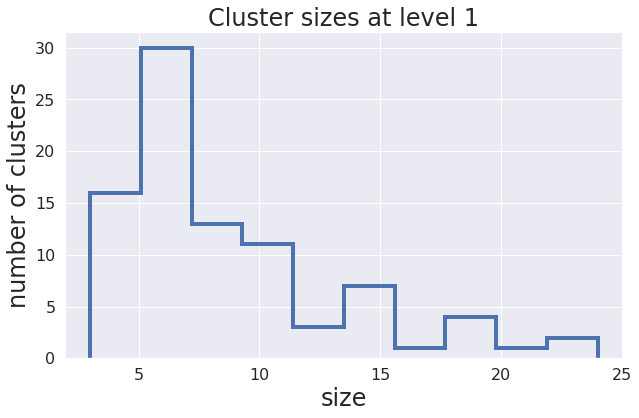

In [16]:
for normalise in [True, False]:
    for label in labels:
        for level in np.arange(L+1)[::-1]:
            if level==0:
                #pass
                continue
            print(normalise, label, level)
            try:
                cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
                fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)

                clustersinfo = get_clustersinfo(cluster,fraction_sites)
                plot_cluster_composition(fraction_sites,directory,level,label=label, normalise=normalise,algorithm=algorithm)
                make_heatmap(fraction_sites, directory, label, level, normalise=normalise,algorithm=algorithm)

                clustersinfo = get_clustersinfo(cluster,fraction_sites)            
                if not normalise:
                    plot_maximum(clustersinfo,cluster,label,level, directory,algorithm=algorithm)
                    plot_maximum_size(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_maximum_label(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_sizes(level,directory, algorithm=algorithm)
            except:
                print(*sys.exc_info())
            continue
            shuffle_files(df_files,label).to_csv("%s/files_shuffles.dat"%directory, index=True)
            fraction_sites_shuffle = get_fraction_sites(cluster, df_files=pd.read_csv("%s/files_shuffles.dat"%directory, index_col=[0]),label=label, normalise=normalise)
            clustersinfo_shuffle = get_clustersinfo(cluster, fraction_sites_shuffle)
            plot_cluster_composition(fraction_sites_shuffle,directory,level, label=label, shuffled=True, normalise=normalise, algorithm=algorithm)
            if not normalise:
                plot_maximum(clustersinfo,cluster,label,level,directory,clustersinfo_shuffle,algorithm=algorithm)
                plot_maximum_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                plot_maximum_label(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                plot_labels_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)

In [ ]:
##useful for R clustree plot
def reindex(x):
    i=0
    last=x[0]
    new = []
    for xi in x:
        if xi == last:
            pass
        else:
            i+=1
            last=xi
        new.append(i)
    return new

df_labels = pd.DataFrame()
shape = df_clusters.dropna().shape
files = pd.read_csv("%s/%s/%s_level_4_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
files = files[files!="nan"]

for level in np.arange(L+1)[::-1]:
    df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,level), header=[0])
    print("level ", level, "with ", df_clusters.shape[1], " clusters")
    currentlevellabels = []
    for file in files:
        s = df_clusters[df_clusters.isin([file])].any(0)
        a = s.index[s]
        currentlevellabels.append(int(a[0][8:])-1)
    df_labels.insert(0,'l%d'%level,currentlevellabels)
    del currentlevellabels
filelabels = []
filesublabels = []
for file in files:
    try:
        filelabels.append(get_file(file, df_files)[labels[0]])
        filesublabels.append(get_file(file, df_files)[labels[1]])
    except:
        filelabels.append('unknown')
        filesublabels.append('unknown')
        print(*sys.exc_info())
df_labels.insert(0,'tissue', filelabels)
df_labels.insert(0,'subtissue', filesublabels)
df_labels.sort_values(by=['tissue','subtissue'], inplace=True)
df_labels.sort_values(by=["l%d"%l for l in np.arange(L+1)[::-1]], axis=0, inplace=True)
filelabels = df_labels['tissue']
filesublabels = df_labels['subtissue']
df_labels = df_labels.apply(reindex, axis=0)
df_labels['tissue']=filelabels
df_labels['subtissue']=filesublabels
df_labels.to_csv("%s/%s/topsbm_labels.csv"%(directory,algorithm), index=False, header=True)

In [ ]:
if "clustersizes.txt" in os.listdir(directory):
    with open("%s/clustersizes.txt"%directory, 'r') as f:
        xl=np.array(f.read().split()).astype(int)
else:
    try:
        xl = getclustersizesarray(directory, L)
        with open("%s/clustersizes.txt" % directory, 'w') as f:
            for x in xl:
                f.write("%d\n" % x)
    except:
        print(*sys.exc_info())
        print("cannot save clustersizes.txt")

if "topicsizes.txt" in os.listdir(directory):
    with open("%s/topicsizes.txt"%directory) as f:
        tl=np.array(f.read().split()).astype(int)
else:
    try:
        tl = gettopicsizesarray(directory, L)
        with open("%s/topicsizes.txt" % directory, 'w') as f:
            for x in tl:
                f.write("%d\n" % x)
    except:
        print("cannot save topicsizes.txt")

In [ ]:
scores = get_scores(directory, labels, verbose=False)
scores['hsbm'] = scores[labels[0]]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')

In [ ]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels, alpha=1)
ax.set_xscale('log')
ax.set_ylim(0,1)

plt.show()
fig.savefig("%s/metric_scores_hierstructure.pdf"%(directory))

In [ ]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
#add_score_lines(ax,scores,[labels[0]],xl, h=True, c=True, alpha=1)
h = np.array(scores['hsbm']['h'])
c = np.array(scores['hsbm']['c'])
ax.plot(scores['hsbm']['xl'],h, marker='o', ls='--', lw=10, ms=40, label='homogeneity')
ax.plot(scores['hsbm']['xl'],c, marker='o', ls='-.', lw=10,ms=40, label='completeness')
ax.plot(scores['hsbm']['xl'],scores['hsbm']['V'], marker='o', ms=40, ls='-', lw=10, label='score')
ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=15)

plt.xlabel('number of clusters', fontsize=35)
plt.ylabel('measure', fontsize=35)
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

In [ ]:
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')

In [ ]:
label = labels[0]
scores = {}
for key,alg in zip(["hsbm","hierarchical","lda","kmeans","tm","wgcna", "nmf"],["topsbm","hierarchical-log","lda","kmeans","tm","wgcna", "nmf"]):
    print(key,alg)
    try:
        scores[key]= get_scores(directory, labels, df_files=df_files, algorithm=alg, verbose=False)[label]
    except:
        print("cannot find ", alg)
        print(*sys.exc_info())
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')

In [ ]:
#label="SMTS"
#scores={}
scores['hierarchical-tpm'] = get_scores(directory, labels, algorithm='hierarchical-tpm', verbose=False)[label]
scores['lda-tpm'] = get_scores(directory, labels, algorithm='lda-tpm', verbose=False)[label]
scores['hsbm-log2'] = get_scores(directory, labels, algorithm='topsbm-log', verbose=False)[label]
scores['hsbm-log10'] = get_scores(directory, labels, algorithm='topsbm-log10', verbose=False)[label]
scores['wgcna-tpm'] = get_scores(directory, labels, algorithm='wgcna-tpm', verbose=False)[label]
scores['hsbm'] = get_scores(directory, labels, algorithm='topsbm', df_files=df_files, verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')

In [ ]:
scores["tissues"] = get_scores(directory, labels, algorithm='topsbm', verbose=False)[labels[0]]
scores["sub_tissues"] = get_scores(directory, labels, algorithm='topsbm', verbose=False)[labels[1]]
scores[labels[0]] = scores["tissues"]
scores[labels[1]] = scores["sub_tissues"]

In [ ]:
from hsbmpy import normalise_score
if "mixed" in scores.keys():
    scores.pop("mixed")
normalise_score(scores, base_algorithm="shuffle", operation=lambda x,y: x/y)

In [ ]:
analyses = {
    "all": ['hsbm', 'tm', 'hierarchical', 'lda', 'wgcna', 'nmf','shuffle'],
    "subtypes": ["Subtype_Selected", "BRCA_Subtype_PAM50",'shuffle'],
    "hsbm": ["hsbm", "hsbm-sweep", "hsbm-log2","hsbm-log10",'shuffle'],
    "subtissues": ["tissues", "sub_tissues",'shuffle'],
    "hvhde": ["hsbm-hde", "hsbm-hv", "shuffle"],
    "wgcna": ["wgcna","wgcna-high","wgcna-low", "shuffle"]
}

In [ ]:
for _,score in scores.items():
    if score["xl"][0]<score["xl"][-1]:
        score["xl"].append(1000)
        score["V"].append(0)
        score["norm_V"]=list(score["norm_V"])
        score["norm_V"].append(1)
    else:
        score["xl"].insert(0,1000)
        score["V"].insert(0,0)
        score["norm_V"]=list(score["norm_V"])
        score["norm_V"].insert(0,1)

In [ ]:
scores = {}
scores['hsbm-hv'] = get_scores("cancers/breast/hv", labels, algorithm='topsbm', df_files=df_files, verbose=False)[labels[0]]
scores['hsbm-hde'] = get_scores("cancers/breast", labels, algorithm='topsbm', df_files=df_files, verbose=False)[labels[0]]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')

In [ ]:
os.listdir("cancers/lung/tests")

In [ ]:
scores={}
scores['wgcna'] = get_scores("cancers/lung/", labels, algorithm='wgcna', verbose=False)[labels[0]]
scores['wgcna-low'] = get_scores("cancers/lung/tests/low_filters", labels, algorithm='wgcna', df_files=df_files, verbose=False)[labels[0]]
scores['wgcna-high'] = get_scores("cancers/lung/tests/high_filters", labels, algorithm='wgcna', df_files=df_files, verbose=False)[labels[0]]
scores['shuffle'] = get_scores_shuffled("cancers/lung/", df_files, label=labels[0], algorithm='wgcna')

In [ ]:
analysis = "all"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
plt.xlim(1,1100)
plt.ylim(0,35)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

In [ ]:
bar_data = {}
bar_data["tpm"] = {}
bar_data["log"] = {}

for alg in ["hsbm", "lda-tpm", "hierarchical-tpm", "wgcna-tpm"]:
    bar_data["tpm"][alg] = max(scores[alg]["V"])
for alg in ["hsbm-log2", "lda", "hierarchical", "wgcna"]:
    bar_data["log"][alg] = max(scores[alg]["V"])
    
n_algs = 4
fig, ax = plt.subplots(figsize=(18,15))
ax.bar([x*2.4 for x in range(n_algs)], list(zip(*bar_data["tpm"].items()))[1],color="gray", label="TPM")
ax.bar([0.8+x*2.4 for x in range(n_algs)], list(zip(*bar_data["log"].items()))[1], color="red", label="Log(TPM+1)")
ax.set_xticklabels(labels=["hsbm","lda", "hierarchical","wgcna"], fontsize=35)
ax.set_xticks([0.4+x*2.4 for x in range(n_algs)])
ax.tick_params(labelsize=35)
ax.set_ylim(0.4,1)
ax.legend(fontsize=35)
ax.set_ylabel("NMI score", fontsize=35)

plt.show()
fig.savefig(f"{directory}/metric_scores_bars_log.pdf")

# Clustering consensus

In [ ]:
clusters = {}
labels = {}
algs = ["topsbm", "tm", "lda", "wgcna", "hierarchical-log"]
for algorithm, l in zip(algs,[1,0, 2, 1, 2]):
    clusters[algorithm]=pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,l), header=[0])
    print(algorithm, clusters[algorithm].shape[1])
    labels[algorithm] = []
    for sample in samples:
        labels[algorithm].append(clusters[algorithm].columns[(clusters[algorithm]==sample).any()].values[0])

In [ ]:
from sklearn.metrics import v_measure_score
for alg1, alg2 in zip(["topsbm", "topsbm", "topsbm", "topsbm", "tm", "tm", "tm", "lda", "lda", "wgcna"],["tm","lda", "wgcna", "hierarchical-log", "lda", "wgcna", "hierarchical-log", "wgcna", "hierarchical-log", "hierarchical-log"]):
    print(alg1, " & ", alg2.replace("-log",""), " & ", "{:.3f}".format(float(v_measure_score(labels[alg1], labels[alg2]))), "\\\\ \hline")

In [ ]:
df_algs = pd.DataFrame(columns = algs, index=algs)
for alg1, alg2 in zip(["topsbm", "topsbm", "topsbm", "topsbm", "tm", "tm", "tm", "lda", "lda", "wgcna"],["tm","lda", "wgcna", "hierarchical-log", "lda", "wgcna", "hierarchical-log", "wgcna", "hierarchical-log", "hierarchical-log"]):
    df_algs.at[alg1,alg2]=float(v_measure_score(labels[alg1], labels[alg2]))
    
df_algs.at["tm", "topsbm"]=0.256
df_algs.at["lda", "topsbm"]=0.051
df_algs.at["wgcna", "topsbm"]=0.058
df_algs.at["lda", "tm"]=0.264
df_algs.at["wgcna", "tm"]=0.656
df_algs.at["wgcna", "lda"]=0.175
import seaborn as sns

cm = sns.clustermap(df_algs.fillna(0.5), vmin=0, vmax=1, row_cluster=False, 
                    col_cluster=False,
                   cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_yticklabels(labels=algs, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=algs, rotation=90)
ax.tick_params(labelsize=35)

ax.text(1,4,"topics", fontsize=35, color="black", rotation = 360-45)
ax.text(2.5,2,"clusters", fontsize=35, color="black", rotation = 360-45)


cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("$NMI$", fontsize=30)
plt.tight_layout()
cm.savefig(f"{directory}/comparisons.pdf")

plt.show()